# Análise de Features para Modelo Supervisionado de Intenções de Busca

No *notebook* [Calibração de Intenções de Busca](04.1_Calibracao_Intencoes_de_Busca.ipynb), fez-se um ajuste fino dos parâmetros utilizados para determinar a intenção de busca realizada por uma pessoa. As intenções, definidas em [Análise de Intenções de Busca](04.0_Analise_de_Intencoes_de_Busca.ipynb), são: 
 - **Foco**: alguém com uma necessidade mais específica e que deseja encontrar a melhor opção dentre as alternativas. Por exemplo, alguém em busca de um móvel para a sala, uma *action figure* para a estante ou doces para uma festa.
 - **Exploração**: uma pessoa que pode ter um objetivo ou necessidade, mas não tem a noção de qual produto exatamente será o melhor. A exemplo disso, pode-se ter alguém querendo presentear uma pessoa, mas sem a noção exata do que sera o presente ou uma pessoa que quer passar por produtos como quem visita um shopping ou feira de artesanatos, para eventualmente encontrar algo que seja de interesse.

Enquanto nos *notebooks* anteriores a determinação das intenções de busca é baseada nos itens de busca com interação, feita de forma não supervisionada, é preciso criar um mecanismo para se determinar a intenção de busca sem a necessidade de gerar resultados de busca e nem de aguardar as interações das pessoas. Assim, o objetivo deste *notebook* é estruturar e estudar os recursos necessários criar um modelo de classificação que consiga determinar, a partir das características da própria busca, se a pessoa tem deseja encontrar um produto específico ou está explorando possibilidades. A criação do modelo evita o custo de geração de resultados de busca e antecipa a intenção sem a necessidade de espera por interações.

## Bibliotecas e Funções

In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import sys
import shutil
from pathlib import Path

# Verificação de tipos
from typing import List, Tuple, Set, Any

# Programação funcional e utilitários
import funcy as fp
import itertools
from functools import partial

# Recursos para texto
import re

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Redução de Dimensionalidade e Análise de Similaridade
#from sklearn.mixture import GaussianMixture

# Rastreamento de experimentos e modelos
import mlflow
#import mlflow.sklearn
from mlflow.tracking import MlflowClient
#from mlflow.models.signature import infer_signature

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2


sys.path.append(str(Path.cwd().parent))
from src import settings
from src.utils.text import extract_artisanal_text_features
from src.utils.notebooks import display_side_by_side
from src.pipeline.training_pipeline import create_feature_matrix

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

## Preparação de Conjunto de Dados com Intenções de Busca

Para trabalhar o problema de definição de intenção de busca com um modelo supervisionado, é preciso adaptar o conjunto de dados conforme os critérios de definições de intenções. Para isso, utiliza-se os recursos criados e calibrados do modelo supervisionado, bem como os dados de treinamento da experimentação, para fazer a validação.

O primeiro passo é carregar os dados.

In [2]:
columns_to_read = ['product_id', 'query', 'title']

frame = pd.read_csv(Path(settings.DATA_PATH).joinpath('interim', 'training.csv'), usecols=columns_to_read)

A seguir, é preciso carregar os recursos utilizados para determinar a intenção de busca a partir das interações dos produtos com interações e processar os dados para categorizar as consultas entre:
- **Não qualificada (-1)**: a consulta não tem o número mínimo de interações para se determinar sua classe;
- ****Exploratória (0)****: a consulta teve interações envolvendo produtos de grupos variados, indicando exploração;
- ****Focada (1)****: a consulta se restringiu predominantemente a um ou poucos grupos de produtos, sugerindo foco.

Para recuperar os critérios de determninação da intenção das buscas, utiliza-se uma identificação de execução (*run_id*) definida a partir da [calibração](04.1_Calibracao_Intencoes_de_Busca.ipynb04.1_Calibracao_Intencoes_de_Busca.ipynb).

In [3]:
run_id = 'b61c0cb7df244c13afab452ee08df0e9'

# Retrieve Mlflow Run Data
mlflow_client = MlflowClient(tracking_uri=str(Path.cwd().parent.joinpath(settings.TRACKING_URI)))
model_run = mlflow_client.get_run(run_id)
artifact_uri = model_run.info.artifact_uri

# Load the set of functions and parameters to preprocess data
unsupervised_intent_model_path = str(Path(model_run.info.artifact_uri).joinpath('log', 'preprocessing_model'))
unsupervised_intent_model = mlflow.pyfunc.load_model(unsupervised_intent_model_path)

hyperparmeters_dict = {param.split('__')[-1]: model_run.data.params.get(param)
                       for param in model_run.data.params
                       if param.startswith('hyperparameters__')}

print('Hyperparameters: ')
display(hyperparmeters_dict)

frame['intent_class'] = unsupervised_intent_model.predict(frame)

Hyperparameters: 


{'entropy_threshold': '0.55',
 'clustering_model': 'GaussianMixture',
 'minimum_number_of_products': '5',
 'embedding_columns': 'title'}

A título de análise de consistência, verifica-se a existência de uma única intenção para cada busca:

In [4]:
aggregated_frame = (frame
                    [['query', 'intent_class']]
                    .astype({'intent_class': str})
                    .drop_duplicates()
                    .assign(intents=1)
                    .groupby('query')
                    .sum()
                    .reset_index()
                    .sort_values(by='intents', ascending=False)
                   )
assert all(aggregated_frame['intents'] == 1), 'Há buscas com mais de uma intenção'
display_side_by_side([aggregated_frame.head(5)], ['Buscas com o maior número de intenções diferentes'])
del aggregated_frame

,query,intents
0,1 ano de namoro,1
3963,manta trico,1
3972,marcador de biblia,1
3971,marabu,1
3970,maquina de cortar fita,1


Exibição do resultado da categorização das intenções de busca de modo não supervisionado.

In [5]:
intention_description_map = {-1: 'Não qualificada',
                             0: 'Busca Exploratória',
                             1: 'Busca Focada'}

frame['intent_description'] = frame['intent_class'].map(intention_description_map)

query_examples_frame = (frame
                        .drop_duplicates('query')
                        .groupby('intent_description')
                        .head(5)
                       )

query_intention_summary_frame = (frame
                                 .drop_duplicates(['query'])
                                 [['intent_description']]
                                 .assign(queries=1)
                                 .groupby('intent_description')
                                 .sum()
                                 .reset_index()
                                 .assign(perc=lambda f: (100 * f['queries'] / f['queries'].sum()).apply(lambda v: f'{v:.2f}%'))
                                )

display_side_by_side([query_intention_summary_frame, query_examples_frame], 
                     ['Distribuição de Intenções de Busca', 'Exemplos de Buscas e Suas Intenções'])
del intention_description_map, query_examples_frame, query_intention_summary_frame

### Criação de Conjuntos de Dados para Experimentação

Considerando o objetivo de criar um modelo para classificar as intenções de busca a partir de suas características, é preciso criar um novo conjunto de dados que contenha apenas as buscas qualificadas (i.e., que tinham uma quantidade mínima de interações) e dividi-lo para as funções de treino, teste e validação. Como já existe um conjunto de dados separado para teste, no contexto da classificação de categorias, ele será utilizado também para esta função -- fazendo o devido tratamento das consultas. 

O conjunto de dados original tem cerca de 38 mil registros envolvendo produtos com interações resultantes de buscas. A separação para dados de análise e treinamento reduz o valor a aproximadamente 32 mil. Ao mudar o foco de trabalho de produtos para buscas únicas, a quantidade de registros cai para 5949 (conforme o notebook de [Análise Exploratória](02.0_Analise_Exploratoria.ipynb)). Esse valor deve ter uma redução adicional para que sejam consideradas apenas as consultas para as quais há número suficiente de produtos com interações, o que fornece a evidência para determinar a sua intenção.

Considerando esse cenário de escassez de dados, em vez de fazer uma nova divisão dos registros em treinamento e validação (o que seria feito a partir de buscas únicas), será mantido apenas um conjunto de treinamento. Para fazer o treinamento e validação de modelos, a proposta é usar *k-fold cross validation*, evitando a perda de dados, mas, ao mesmo tempo, mantendo a possibilidade de avaliar a capacidade de generalização e aprendizagem do modelo. Por fim, o conjunto de teste deve fornecer a estimativa final de eficácia do modelo com dados não vistos anteriormente.

In [6]:
qualified_queries_frame = (frame
                           .query("intent_class in (0, 1)")
                           [['query', 'intent_class', 'intent_description']]
                           .drop_duplicates('query')
                          )
selected_columns = ['query', 'intent_class', 'intent_description']

# Select only query and label value and description
train_frame = qualified_queries_frame[selected_columns]

# Shuffle and salve file for future experiments
train_frame.sample(frac=1., random_state=293).to_csv(Path.cwd().parent.joinpath('data', 'interim', 'query_intent_training.csv'), index=False)

Após filtrar as consultas para as qualificadas e manter a classificação da intenção, é possível avaliar a distribuição das classes. Como observado anteriormente, o conjunto é desbalanceado e apresenta mais de 3 registros de intenção "exploratória" para cada intenção de "foco". 

In [7]:
def summarize_classes(base_frame: pd.DataFrame) -> pd.DataFrame:
    return (base_frame
            .assign(queries=1)
            .drop(columns=['intent_class'])
            .groupby('intent_description')
            .sum()
            .reset_index()
            .assign(perc=lambda f: (100 * f['queries'] / f['queries'].sum()).apply(lambda v: f'{v:.2f}%'))
           )

display_side_by_side([summarize_classes(train_frame)],
                     [f'Treinamento ({len(train_frame)})'])

,intent_description,queries,perc
0,Busca Exploratória,1570,75.34%
1,Busca Focada,514,24.66%


### Engenharia de Características

Como é preciso tentar identificar uma busca como exploratória ou focada sem precisar esperar a interação do usuário e nem tentar usar buscas semelhantes, é preciso tentar extrair caracerísticas da consulta para criar um classificador a partir delas.

Além de ser possível usar o próprio conteúdo das buscas, representados por *embeddings*, pode-se extrair características mais específicas da composição, como:
 - Quantidade de caracteres e palavras;
 - Quantidade de caracteres ou palavras formadas por letras, números, espaços e outros símbolos;
 - Tamanho máxio da palavra encontrada na busca;
 - Presença de letras maiúsculas;
 
A suposição é que essas características possam ajudar a determinar situações em que um nome próprio esteja presente, existe uma especificação de característica de produto (e.g., dimensões ou modelo) ou que seja possível perceber um direcionamento maior para restringir o resultado.

A exemplo disso, faz-se a extração artesanal de características baseadas nas palavras e nos caracteres que compõem cada consulta.

In [8]:
word_pattern = re.compile(r'\W')

features_frame = (train_frame
                  .assign(word_level_features=lambda f: f['query'].apply(lambda q: extract_artisanal_text_features(q, word_pattern)))
                  .assign(char_level_features=lambda f: f['query'].apply(extract_artisanal_text_features))
                 )

display_side_by_side([features_frame.head(10)], ['Consultas com Características Extraídas Artesanalmente'])

,query,intent_class,intent_description,word_level_features,char_level_features
0,espirito santo,0,Busca Exploratória,"[2, 8, 0, 0, 2, 0, 2, 0]","[14, 1, 0, 0, 13, 0, 13, 1]"
1,cartao de visita,0,Busca Exploratória,"[3, 6, 0, 0, 3, 0, 3, 0]","[16, 1, 0, 0, 14, 0, 14, 2]"
2,medidas lencol para berco americano,0,Busca Exploratória,"[5, 9, 0, 0, 5, 0, 5, 0]","[35, 1, 0, 0, 31, 0, 31, 4]"
3,adesivo box banheiro,0,Busca Exploratória,"[3, 8, 0, 0, 3, 0, 3, 0]","[20, 1, 0, 0, 18, 0, 18, 2]"
4,dia dos pais,1,Busca Focada,"[3, 4, 0, 0, 3, 0, 3, 0]","[12, 1, 0, 0, 10, 0, 10, 2]"
6,lembrancinha maternidade,0,Busca Exploratória,"[2, 12, 0, 0, 2, 0, 2, 0]","[24, 1, 0, 0, 23, 0, 23, 1]"
7,chaveiro dia dos pais,0,Busca Exploratória,"[4, 8, 0, 0, 4, 0, 4, 0]","[21, 1, 0, 0, 18, 0, 18, 3]"
8,manta personalizada,0,Busca Exploratória,"[2, 13, 0, 0, 2, 0, 2, 0]","[19, 1, 0, 0, 18, 0, 18, 1]"
9,pais,1,Busca Focada,"[1, 4, 0, 0, 1, 0, 1, 0]","[4, 1, 0, 0, 4, 0, 4, 0]"
10,cha de panela,0,Busca Exploratória,"[3, 6, 0, 0, 3, 0, 3, 0]","[13, 1, 0, 0, 11, 0, 11, 2]"


A partir das características extraídas, pode-se tentar avaliar a relação entre as caracerísticas e a intenção da busca.

/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


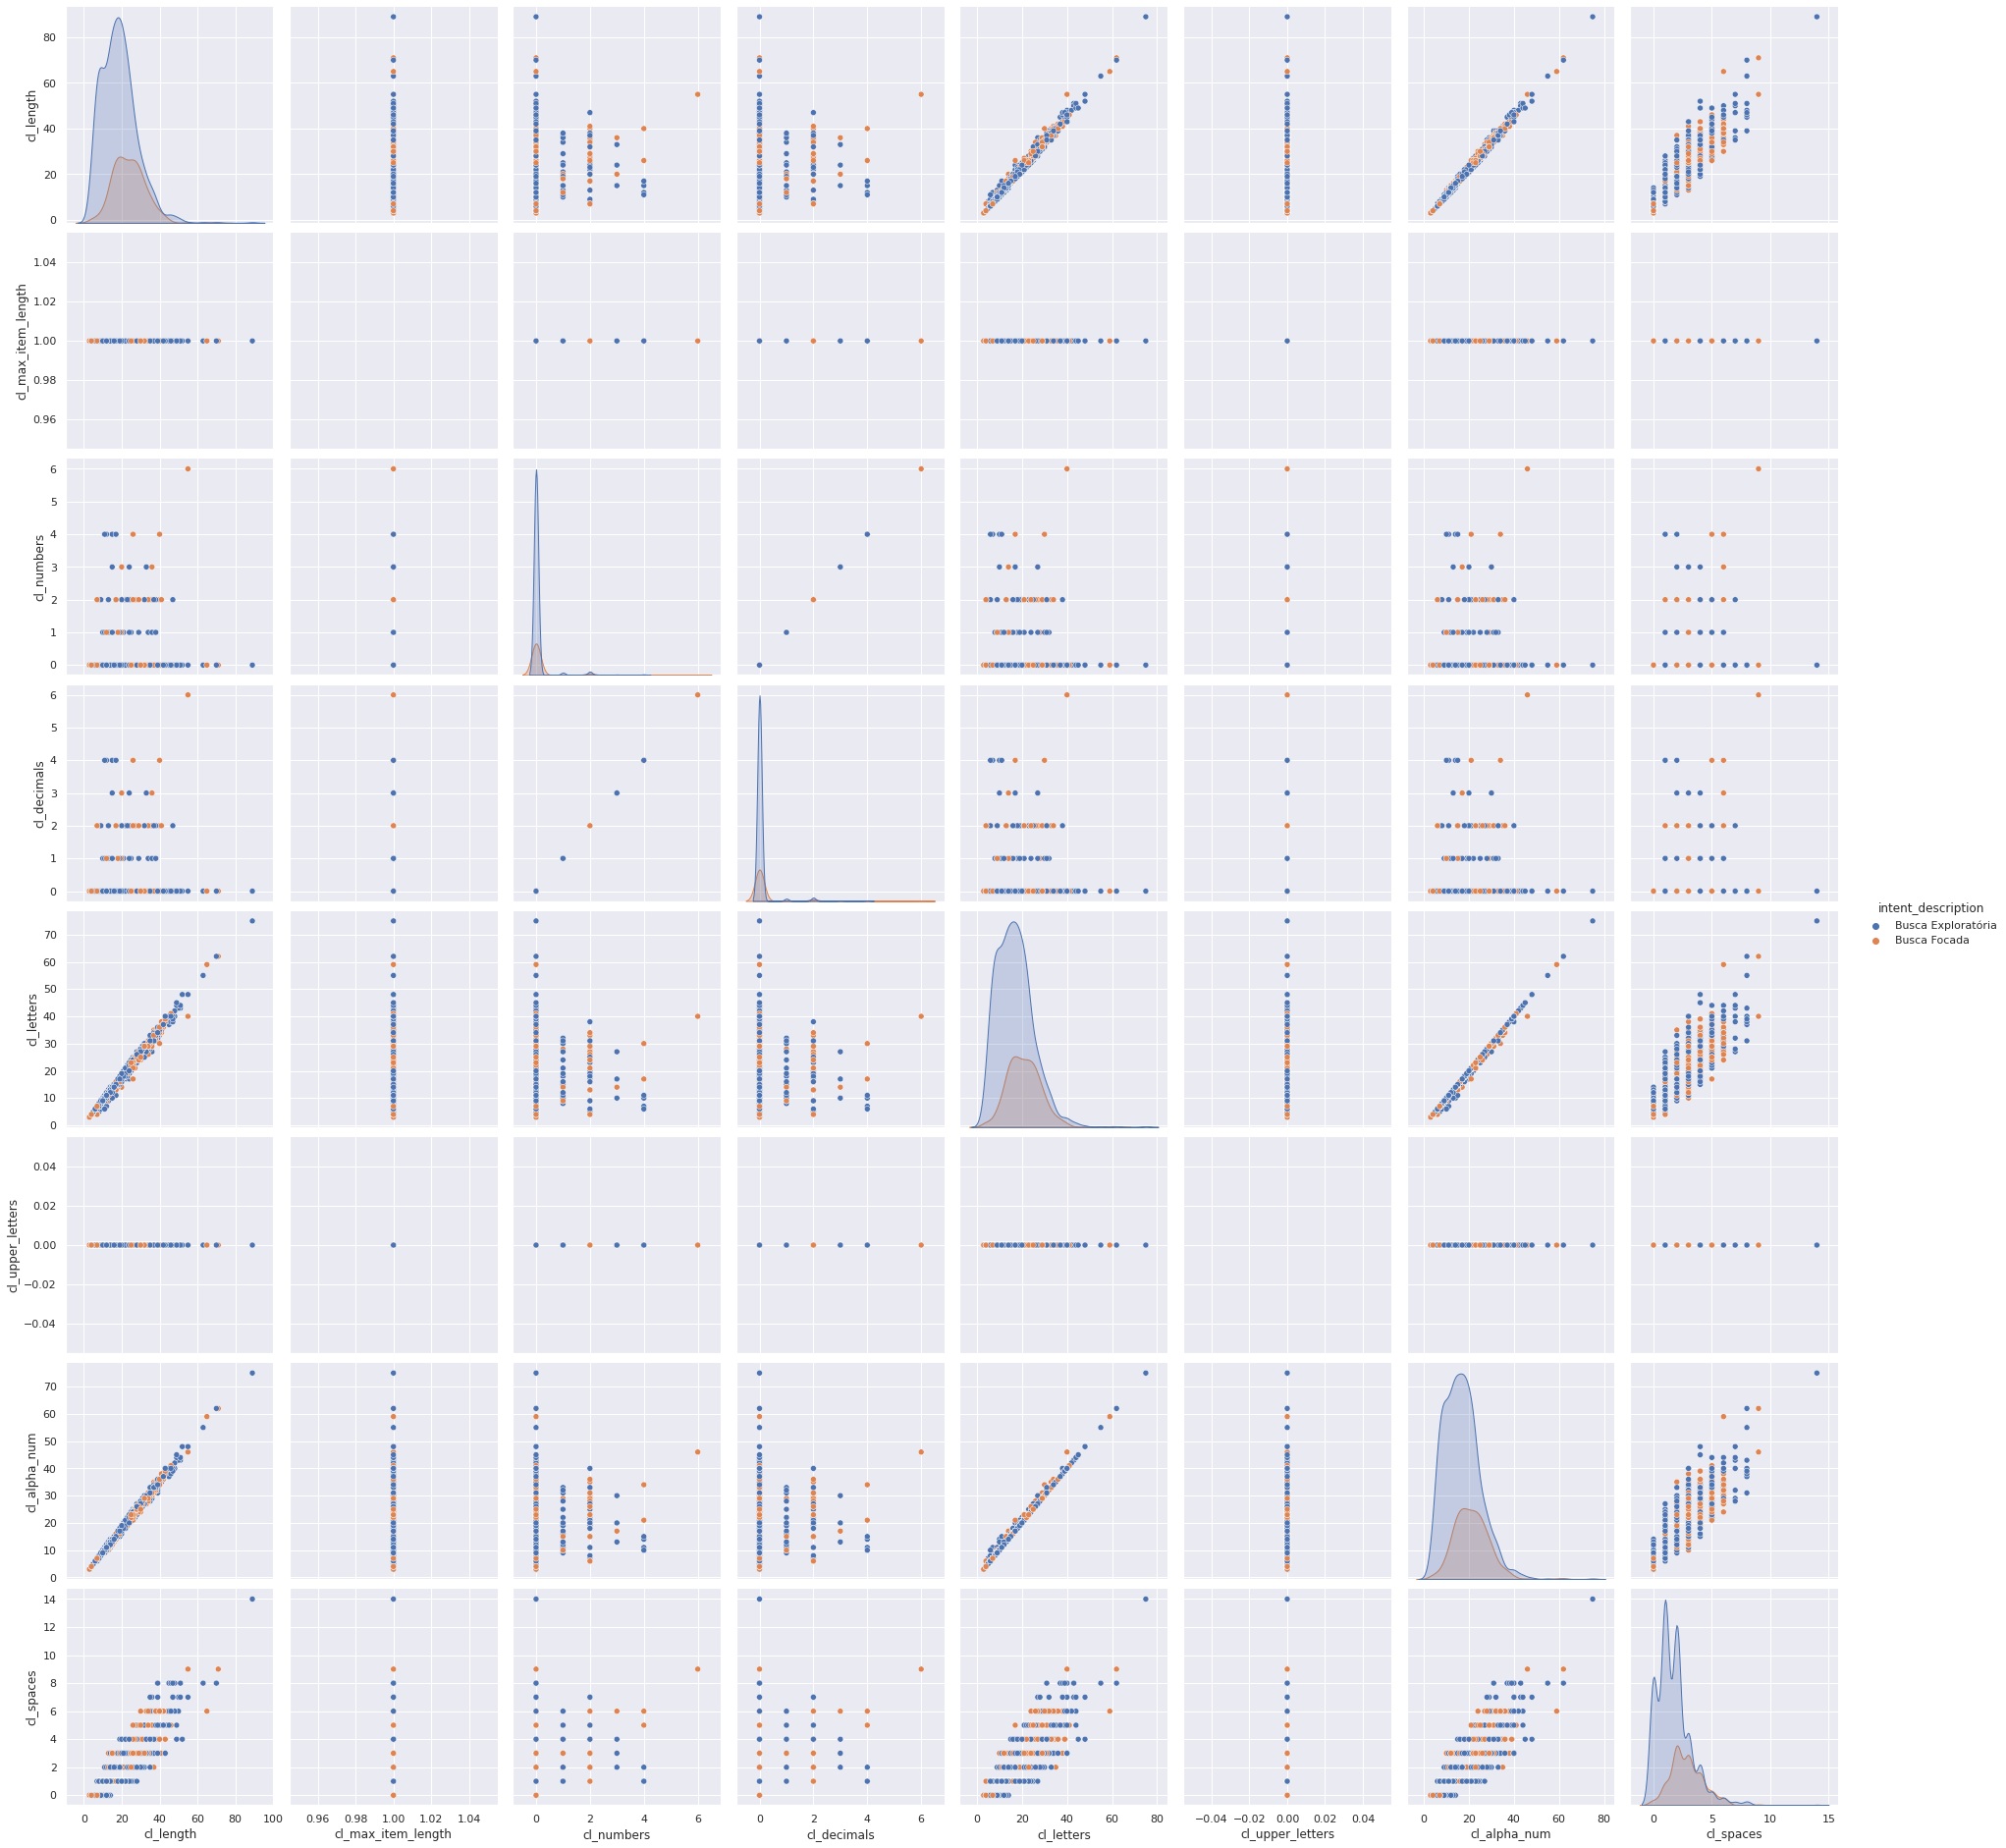

/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


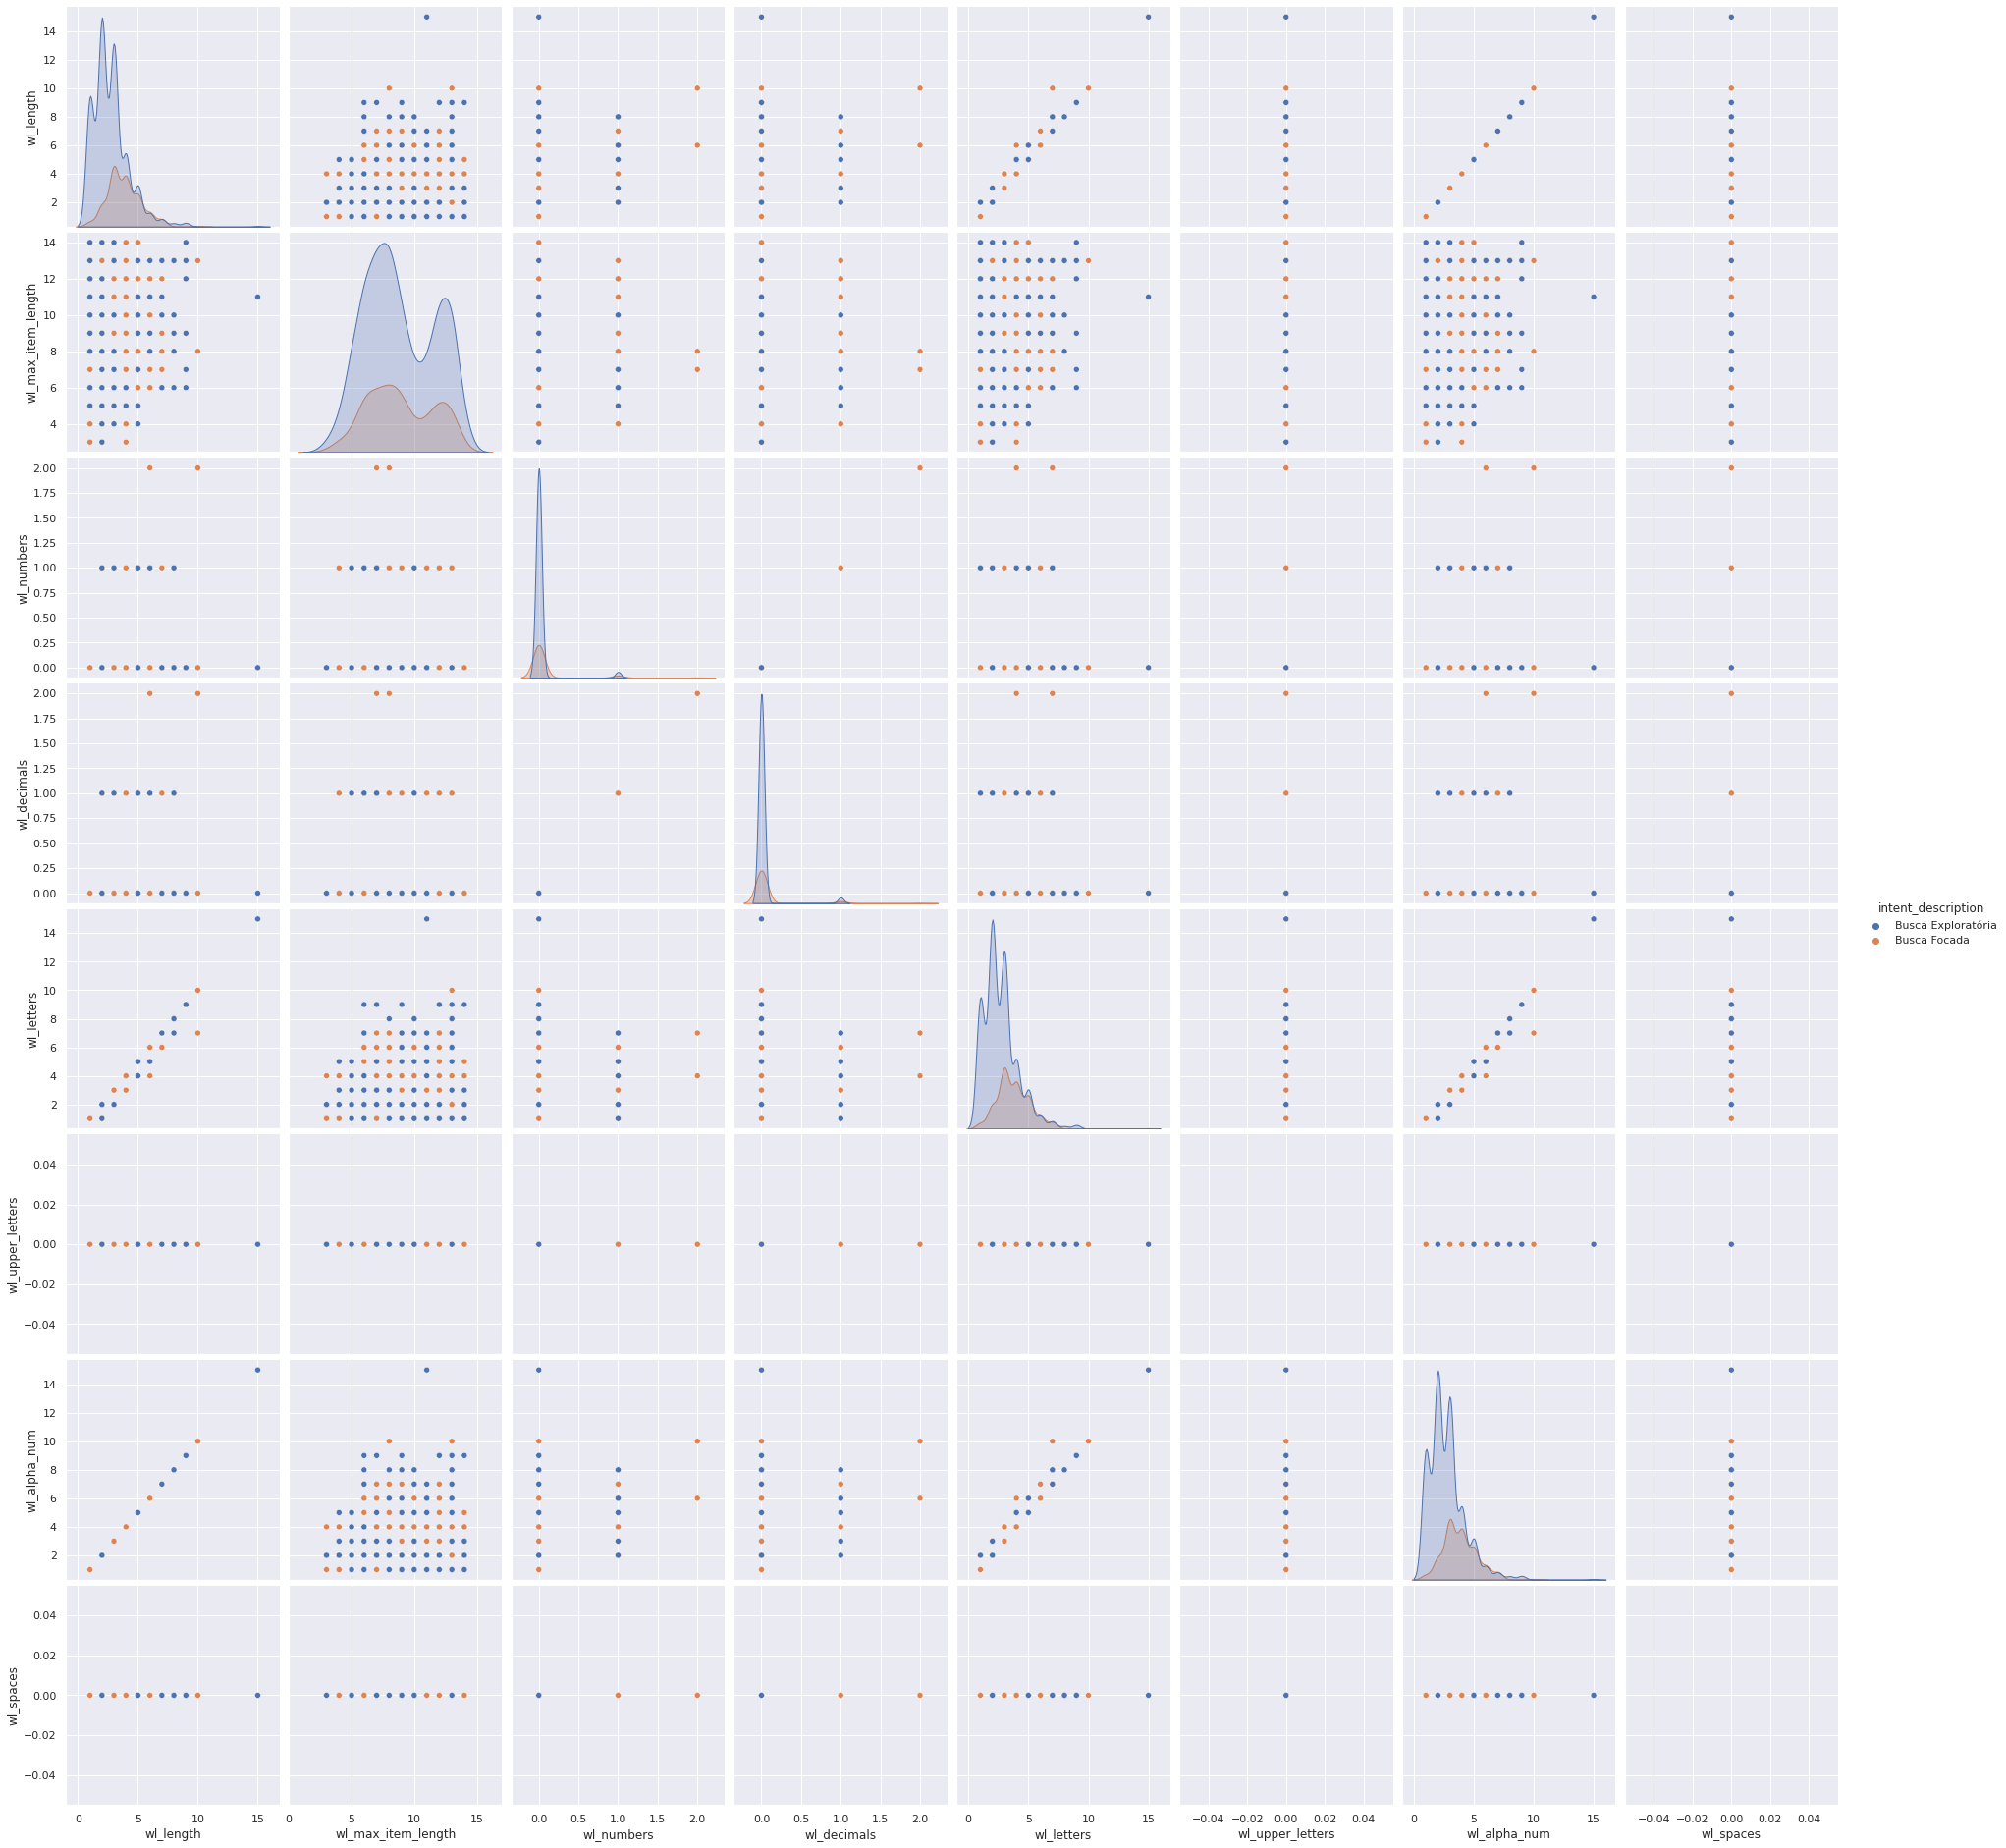

In [9]:
artisanal_features =  ['length', 'max_item_length', 'numbers', 'decimals', 'letters', 'upper_letters', 'alpha_num', 'spaces']
word_level_columns = [f'wl_{feature}' for feature in artisanal_features]
char_level_columns = [f'cl_{feature}' for feature in artisanal_features]

features_matrix = create_feature_matrix(features_frame,
                                        feature_columns=[],
                                        embeddings_columns=['word_level_features', 'char_level_features'])

features_matrix = pd.DataFrame(features_matrix, columns=word_level_columns+char_level_columns)
features_frame = pd.concat([features_frame[['query', 'intent_class', 'intent_description']].reset_index(drop=True),
                            features_matrix.reset_index(drop=True)],
                           axis=1, ignore_index=False)

display(HTML('<h3>Características Extraídas por Caracteres</h3>'))
intent_summary_plot = sns.pairplot(features_frame[['intent_description'] + char_level_columns],
                                   height=3.33, hue='intent_description'
                                  )
plt.show()


display(HTML('<h3>Características Extraídas por Palavras</h3>'))
intent_summary_plot = sns.pairplot(features_frame[['intent_description'] + word_level_columns],
                                   height=3.33, hue='intent_description'
                                  )
plt.show()

del features_frame, artisanal_features, features_matrix, intent_summary_plot

Um ponto relevante das características extraídas da busca é a independência dos resultados, o que impede o vazamento de informações entre os dados de treinamento e validação. Assim, ao realizar o *k-fold cross validation*, pode-se fazer o processamento completos dos dados e, posteriormente, fazer as diferentes segmentações sem comprometer a validade da experimentação.